# Semi-supervised AQI Classification — Co-Training

- Mục tiêu: chạy co-training theo **2 views** (mặc định: view theo pattern thời gian/station và phần còn lại).
- Output: metrics JSON + sample predictions + sample alerts.
- Mini project: tự thiết kế VIEW1_COLS / VIEW2_COLS và chứng minh view tốt.

In [1]:
SEMI_DATASET_PATH = "data/processed/dataset_for_semi.parquet"
CUTOFF = "2017-01-01"

TAU = 0.90
MAX_ITER = 10
MAX_NEW_PER_ITER = 500
MIN_NEW_PER_ITER = 20
VAL_FRAC = 0.20
RANDOM_STATE = 42

METRICS_PATH = "data/processed/metrics_co_training.json"
PRED_SAMPLE_PATH = "data/processed/predictions_co_training_sample.csv"
ALERTS_SAMPLE_PATH = "data/processed/alerts_co_training_sample.csv"
ALERT_FROM_CLASS = "Unhealthy"

# Q2.B1: TÁCH 2 VIEW
# View A – Mức độ ô nhiễm trực tiếp(Pollution (Model A))
VIEW1_COLS = [
    "PM2.5", "PM10", "SO2", "NO2", "CO", "O3"
]

# View B – Điều kiện khí tượng ảnh hưởng gián tiếp đến AQI(Meteorology (Model B))
VIEW2_COLS = [
    "TEMP", "PRES", "DEWP", "RAIN", "WSPM"
]

In [2]:
# Parameters
SEMI_DATASET_PATH = "data/processed/dataset_for_semi.parquet"
CUTOFF = "2017-01-01"
TAU = 0.9
MAX_ITER = 10
MAX_NEW_PER_ITER = 500
MIN_NEW_PER_ITER = 20
VAL_FRAC = 0.2
RANDOM_STATE = 42
METRICS_PATH = "data/processed/metrics_co_training.json"
PRED_SAMPLE_PATH = "data/processed/predictions_co_training_sample.csv"
ALERTS_SAMPLE_PATH = "data/processed/alerts_co_training_sample.csv"
ALERT_FROM_CLASS = "Unhealthy"
VIEW1_COLS = None
VIEW2_COLS = None


,iter,val_accuracy,val_f1_macro,unlabeled_pool,new_pseudo,tau
0,1,0.722615,0.650160,383962,500,0.9
1,2,0.731954,0.674442,383462,500,0.9
2,3,0.721858,0.663235,382962,500,0.9
3,4,0.724634,0.654396,382462,500,0.9
4,5,0.719334,0.654924,381962,500,0.9
5,6,0.722615,0.658462,381462,500,0.9
6,7,0.724634,0.660198,380962,500,0.9
7,8,0.718072,0.646787,380462,500,0.9
8,9,0.717314,0.637757,379962,500,0.9
9,10,0.716810,0.646121,379462,500,0.9


Test accuracy: 0.5335012896646871
Test f1_macro: 0.404431750461202


{'view1_cols': ['No',
  'PM10',
  'SO2',
  'NO2',
  'CO',
  'O3',
  'TEMP',
  'PRES',
  'DEWP',
  'RAIN',
  'WSPM',
  'PM10_lag1',
  'SO2_lag1',
  'NO2_lag1',
  'CO_lag1',
  'O3_lag1',
  'TEMP_lag1',
  'PRES_lag1',
  'DEWP_lag1',
  'RAIN_lag1',
  'WSPM_lag1',
  'PM10_lag3',
  'SO2_lag3',
  'NO2_lag3',
  'CO_lag3',
  'O3_lag3',
  'TEMP_lag3',
  'PRES_lag3',
  'DEWP_lag3',
  'RAIN_lag3',
  'WSPM_lag3',
  'PM10_lag24',
  'SO2_lag24',
  'NO2_lag24',
  'CO_lag24',
  'O3_lag24',
  'TEMP_lag24',
  'PRES_lag24',
  'DEWP_lag24',
  'RAIN_lag24',
  'WSPM_lag24',
  'is_labeled'],
 'view2_cols': ['year',
  'month',
  'day',
  'hour',
  'wd',
  'station',
  'hour_sin',
  'hour_cos',
  'dow',
  'is_weekend'],
 'view1_numeric_cols': ['No',
  'PM10',
  'SO2',
  'NO2',
  'CO',
  'O3',
  'TEMP',
  'PRES',
  'DEWP',
  'RAIN',
  'WSPM',
  'PM10_lag1',
  'SO2_lag1',
  'NO2_lag1',
  'CO_lag1',
  'O3_lag1',
  'TEMP_lag1',
  'PRES_lag1',
  'DEWP_lag1',
  'RAIN_lag1',
  'WSPM_lag1',
  'PM10_lag3',
  'SO2_lag3',

Saved history table: D:\ki2nam4\datamining\air_guard\data\processed\history_co_training.csv


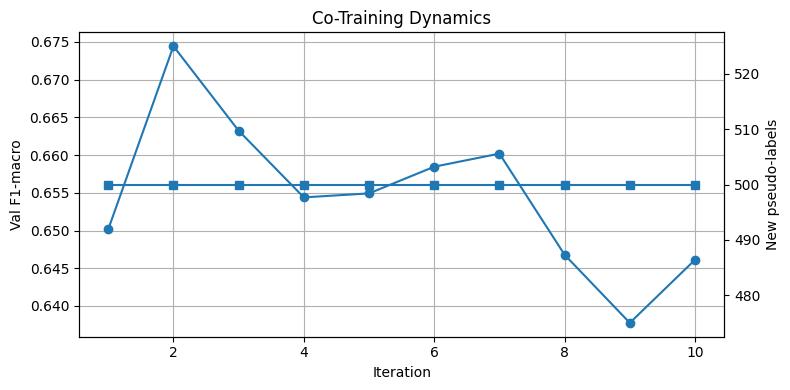

Saved dynamics figure: D:\ki2nam4\datamining\air_guard\data\processed\co_training_dynamics.png
Saved: D:\ki2nam4\datamining\air_guard\data\processed\metrics_co_training.json
Saved: D:\ki2nam4\datamining\air_guard\data\processed\predictions_co_training_sample.csv
Saved: D:\ki2nam4\datamining\air_guard\data\processed\alerts_co_training_sample.csv


In [3]:
from pathlib import Path
import json
import pandas as pd
import matplotlib.pyplot as plt

from src.semi_supervised_library import (
    SemiDataConfig, CoTrainingConfig, run_co_training, add_alert_columns
)

# ===============================
# 1. LOAD DATA
# ===============================
PROJECT_ROOT = Path(".").resolve()
if not (PROJECT_ROOT / "data").exists() and (PROJECT_ROOT.parent / "data").exists():
    PROJECT_ROOT = PROJECT_ROOT.parent.resolve()

df = pd.read_parquet((PROJECT_ROOT / SEMI_DATASET_PATH).resolve())

# ===============================
# 2. CONFIGURATION
# ===============================
data_cfg = SemiDataConfig(
    cutoff=CUTOFF,
    random_state=int(RANDOM_STATE)
)

ct_cfg = CoTrainingConfig(
    tau=float(TAU),                     # Ngưỡng self-labeling τ
    max_iter=int(MAX_ITER),
    max_new_per_iter=int(MAX_NEW_PER_ITER),
    min_new_per_iter=int(MIN_NEW_PER_ITER),
    val_frac=float(VAL_FRAC),
)

# ===============================
# 3. RUN CO-TRAINING
# ===============================
out = run_co_training(
    df,
    data_cfg,
    ct_cfg,
    view1_cols=VIEW1_COLS,   # View A
    view2_cols=VIEW2_COLS    # View B
)

# ===============================
# 4. COLLECT RESULTS
# ===============================
history = pd.DataFrame(out["history"])   # [2.3] Bảng theo dõi diễn biến qua từng vòng co-training
pred_df = out["pred_df"]
test_metrics = out["test_metrics"]

# ===============================
# 5. DISPLAY RESULTS
# ===============================
display(history)  # [2.3] Hiển thị bảng: mỗi vòng thêm bao nhiêu pseudo-label, val metrics
print("Test accuracy:", test_metrics["accuracy"])
print("Test f1_macro:", test_metrics["f1_macro"])
display(out["model_info"])

# ===============================
# 6. SAVE HISTORY TABLE
# ===============================
HISTORY_PATH = "data/processed/history_co_training.csv"   # [2.3] Lưu bảng theo dõi co-training

history_path = (PROJECT_ROOT / HISTORY_PATH).resolve()
history_path.parent.mkdir(parents=True, exist_ok=True)
history.to_csv(history_path, index=False)                  # [2.3] Bảng phục vụ phân tích diễn biến

print("Saved history table:", history_path)

# ===============================
# 7. PLOT & SAVE CO-TRAINING DYNAMICS
# ===============================
FIG_PATH = "data/processed/co_training_dynamics.png"       # [2.3] Biểu đồ theo dõi diễn biến

fig, ax1 = plt.subplots(figsize=(8, 4))

# [2.3] Trục trái: Validation F1-macro theo từng vòng
ax1.plot(
    history["iter"],
    history["val_f1_macro"],
    marker="o",
    label="Val F1-macro"
)
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Val F1-macro")
ax1.grid(True)

# [2.3] Trục phải: Số lượng pseudo-label được thêm mỗi vòng
ax2 = ax1.twinx()
ax2.plot(
    history["iter"],
    history["new_pseudo"],
    marker="s",
    label="New pseudo-labels"
)
ax2.set_ylabel("New pseudo-labels")

plt.title("Co-Training Dynamics")
fig.tight_layout()

fig_path = (PROJECT_ROOT / FIG_PATH).resolve()
plt.savefig(fig_path)    # [2.3] Lưu biểu đồ để đưa vào báo cáo
plt.show()

print("Saved dynamics figure:", fig_path)

# ===============================
# 8. SAVE OTHER ARTIFACTS
# ===============================
metrics_path = (PROJECT_ROOT / METRICS_PATH).resolve()
pred_path = (PROJECT_ROOT / PRED_SAMPLE_PATH).resolve()
alerts_path = (PROJECT_ROOT / ALERTS_SAMPLE_PATH).resolve()

for p in [metrics_path, pred_path, alerts_path]:
    p.parent.mkdir(parents=True, exist_ok=True)

payload = {
    "method": "co_training",
    "data_cfg": data_cfg.__dict__,
    "ct_cfg": ct_cfg.__dict__,
    "history": out["history"],           # [2.3] Log toàn bộ diễn biến co-training
    "test_metrics": test_metrics,
    "model_info": out["model_info"],
}

with open(metrics_path, "w", encoding="utf-8") as f:
    json.dump(payload, f, ensure_ascii=False, indent=2)

pred_df.head(5000).to_csv(pred_path, index=False)

alerts = add_alert_columns(
    pred_df,
    pred_col="y_pred",
    severe_from=ALERT_FROM_CLASS
)
alerts.head(5000).to_csv(alerts_path, index=False)

print("Saved:", metrics_path)
print("Saved:", pred_path)
print("Saved:", alerts_path)